In [209]:
import config
import pandas as pd
import sys
import geopandas as gpd
from shapely.geometry import Point
from geopandas import GeoSeries
import contextily as cx
import numpy as np

#读取文件
sys.path.append('src/fetch/')
from config import address_cleaned_file, district_file, macro_file, geo_file
street_map_file = 'data/map/street/上海市_乡镇边界.shp'
# SHAPE_RESTORE_SHX=YES fio info data/map/shanghai_street.shp

address = pd.read_csv(address_cleaned_file)
district = pd.read_csv(district_file)
city = pd.read_csv(macro_file)
geo = pd.read_csv(geo_file)

In [210]:
#将地址和每日病例地址merge
complete_address = pd.merge(address, geo)
complete_address.head()
complete_address.shape
complete_address.describe()
complete_address['date_value'] = complete_address.date.apply(lambda x: pd.Timestamp(str(x)[:4] + '-' + str(x)[4:6] + '-' + str(x)[6:]))
complete_address.groupby(['street_level','district']).agg('median')

NameError: name 'merge_geo_address_file' is not defined

In [212]:
street = pd.DataFrame(complete_address.groupby(['date', 'date_value', 'district', 'street_level'], as_index = False).size())
street.head()
street_daily = street.pivot_table(index = 'date_value', columns = 'street_level', values = 'size')
street_daily = street_daily.fillna(0)

<AxesSubplot:>

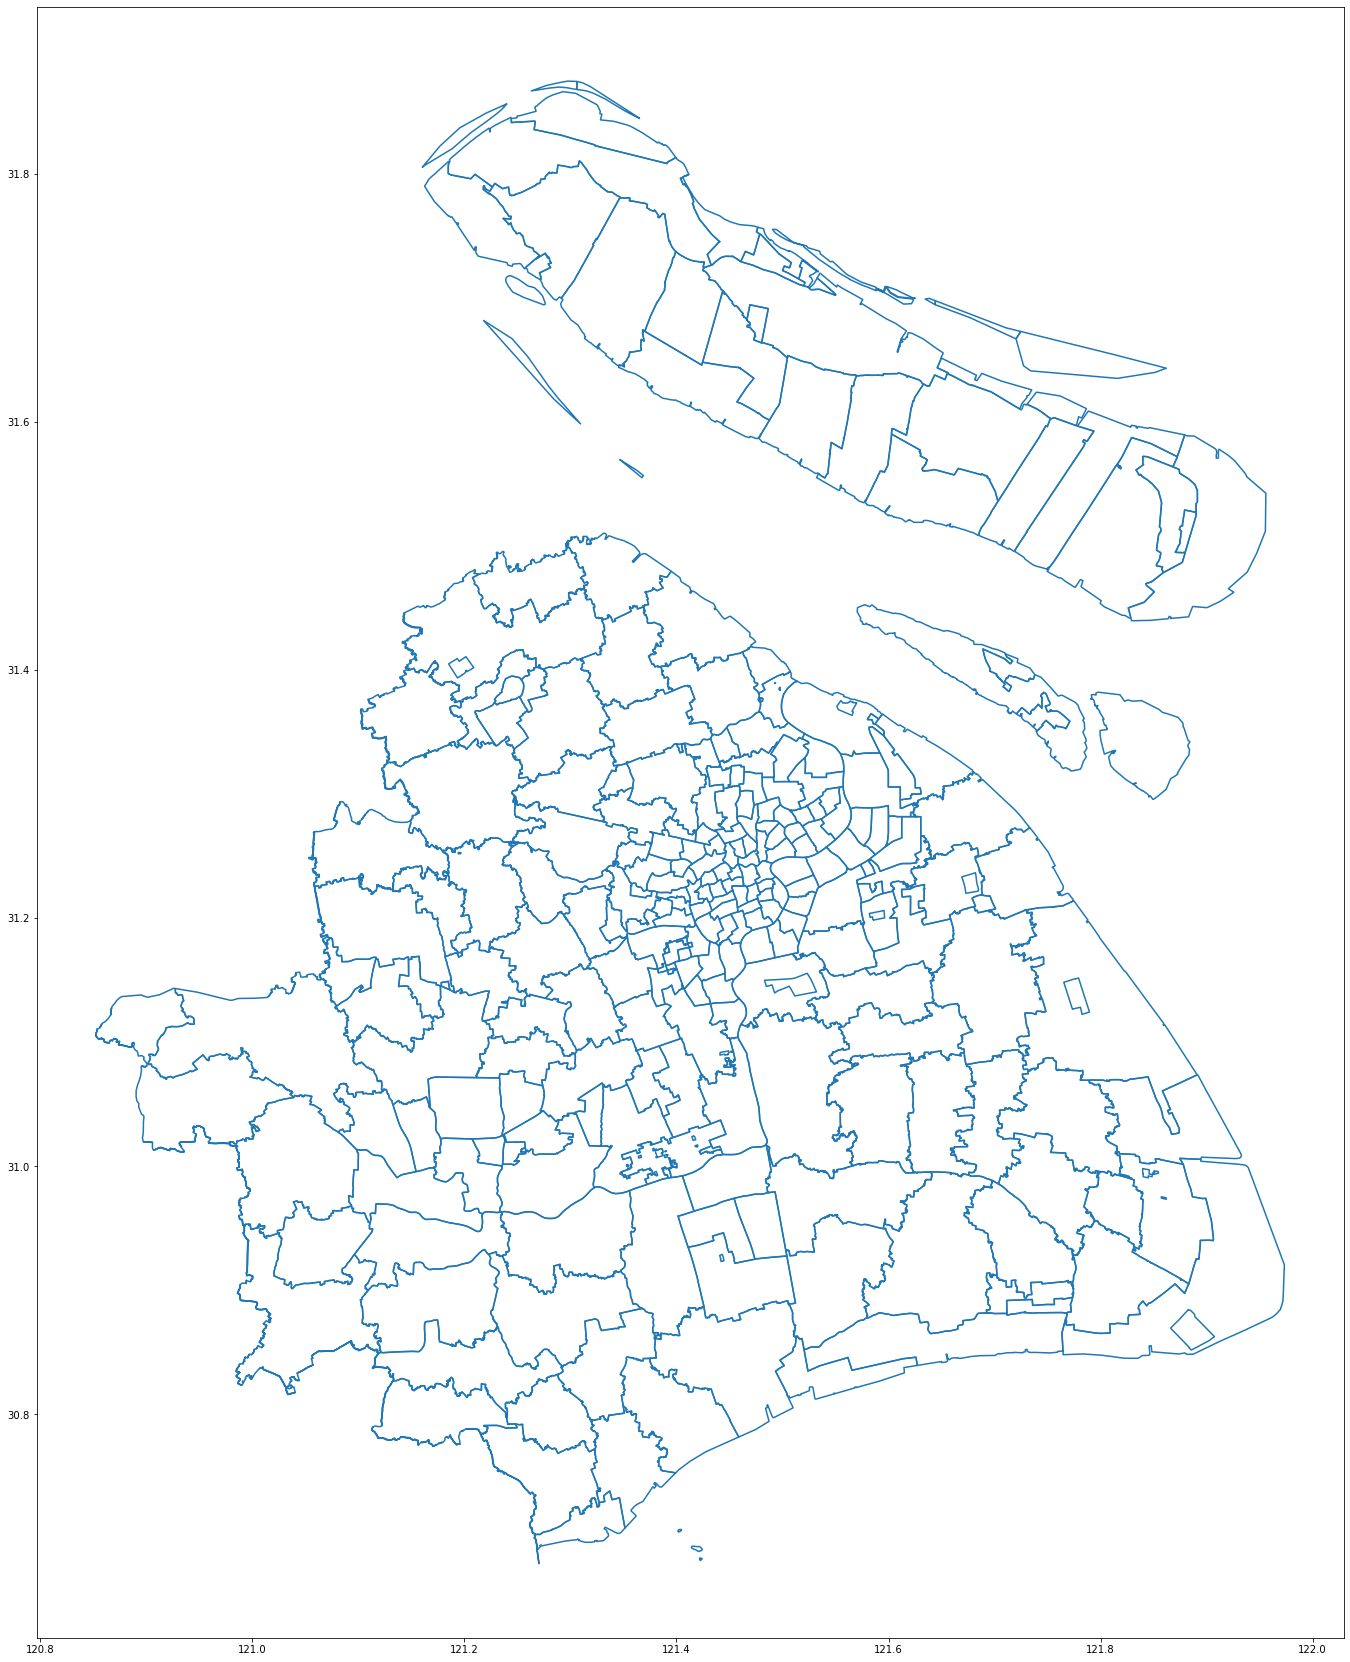

In [221]:
street_map = gpd.read_file(street_map_file, encoding = 'GB2312')
street_map.boundary.plot(figsize=(100, 30))

In [214]:
complete_geo = complete_address[['date', 'date_value', 'district', 'street_level', 'wgs84_lng', 'wgs84_lat']]
street_map = street_map.set_crs(epsg=4326)
xc = complete_geo['wgs84_lat']
yc = complete_geo['wgs84_lng']
pts = GeoSeries([Point(x, y) for x, y in zip(xc, yc)])
circles = pts.buffer(5000)
mp = circles.unary_union
holes = street_map['geometry'].intersection(mp)

/usr/local/var/pyenv/versions/anaconda3-5.2.0/lib/python3.7/site-packages/contextily/tile.py:581: UserWarning: The inferred zoom level of 26 is not valid for the current tile provider (valid zooms: 0 - 20).
  warnings.warn(msg)


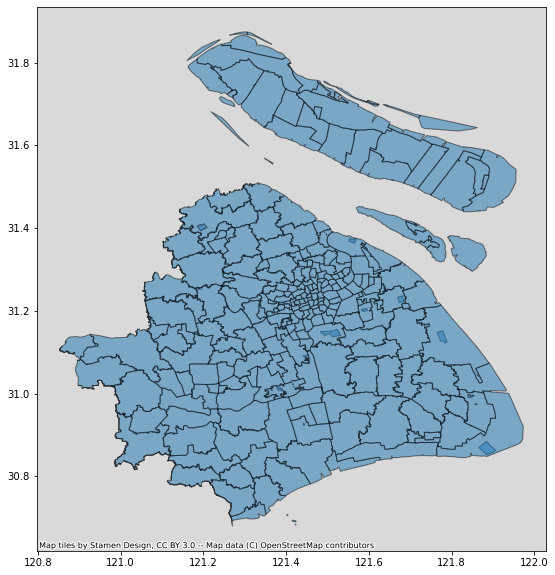

In [223]:
#street_map.boundary.explore()
ax = street_map.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')
cx.add_basemap(ax, source=cx.providers.Stamen.TonerLite)
cx.add_basemap(ax, source=cx.providers.Stamen.TonerLabels)

In [222]:
#不根据街道只根据点的绝对位置判断
def return_street(point, area, value_string):
#    print(point, area)
    mask = area['geometry'].apply(lambda x: point.contains(x))
    value = ''
    if area[mask].shape[0] > 0:   
        value = area[mask][value_string].iloc[0]
    print(value)
    return 
street_map['geometry'].apply(lambda x:return_street(x, complete_geo_seg, 'district'))
#complete_geo_seg= gpd.GeoDataFrame(
#    complete_geo, geometry=gpd.points_from_xy(complete_geo.wgs84_lng, complete_geo.wgs84_lat))
#dates = complete_geo_seg.date.unique()
#dates.sort()
#for index, row in street_map.iterrows():
#    po = row['geometry']
#    count = 0
#    for date in dates:
#        row['count'] = sum(complete_geo_seg[complete_geo_seg['date'] == date]['geometry'].apply(lambda x: po.contains(x)))
        

KeyboardInterrupt: 

In [215]:
complete_geo_seg = complete_geo_seg.set_crs(epsg=4326)

In [216]:
dfsjoin = gpd.sjoin(street_map, complete_geo_seg[['date', 'geometry', 'district']]) #Spatial join Points to polygons
dfpivot = pd.pivot_table(dfsjoin,index='Name',columns='date',aggfunc={'date':len})
dfpivot.columns = dfpivot.columns.droplevel()
dfpolynew = street_map.merge(dfpivot, how='left', on='Name')
dfpolynew.plot(column=20220420, figsize=(30, 10))

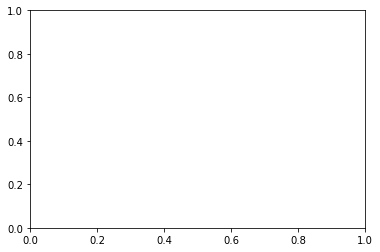

In [139]:
%matplotlib inline
matplotlib.use('tkagg')
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
dates = complete_geo_seg.date.unique()
dates.sort()
fig, ax = plt.subplots()
ims = []
def update_fig(date):
    if len(ims) > 0:
        ims[0].remove()
        del ims[0]
    pic = gpd.plotting.plot_polygon_collection(ax, dfpolynew['geometry'].values,dfpolynew[date], True, cmap="Reds")
    ims.append(pic)
    pic.set_title('date = ' + str(year))
    return ims
anim = FuncAnimation(fig, update_fig, interval=1000, repeat_delay=3000, frames=dates)
anim
fig.show()

In [ ]:
dfpolynew.explore(
     column="BoroName", # make choropleth based on "BoroName" column
     tooltip="BoroName", # show "BoroName" value in tooltip (on hover)
     popup=True, # show all values in popup (on click)
     tiles="CartoDB positron", # use "CartoDB positron" tiles
     cmap="Set1", # use "Set1" matplotlib colormap
     style_kwds=dict(color="black") # use black outline
    )